In [3]:
import torch
import torch.utils
import torch.utils.data
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import argparse
import utils
import dataset
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class NoiseScheduler():
    """
    Noise scheduler for the DDPM model

    Args:
        num_timesteps: int, the number of timesteps
        type: str, the type of scheduler to use
        **kwargs: additional arguments for the scheduler

    This object sets up all the constants like alpha, beta, sigma, etc. required for the DDPM model
    
    """
    def __init__(self, num_timesteps=50, type="linear", **kwargs):

        self.num_timesteps = num_timesteps
        self.type = type

        if type == "linear":
            self.init_linear_schedule(**kwargs)
        elif type == "cosine":
            self.init_cosine_schedule(**kwargs)
        elif type == "sigmoid":
            self.init_sigmoid_schedule(**kwargs)
        else:
            raise NotImplementedError(f"{type} scheduler is not implemented") # change this if you implement additional schedulers


    def init_linear_schedule(self, beta_start, beta_end):
        """
        Initialise alpha and beta for linear noise scheduler

        Args:
            beta_start: Starting value of beta (the initial noise)
            beta_end: The final value of beta (that is addded at the last time-step)
        """

        self.betas = torch.linspace(beta_start, beta_end, self.num_timesteps, dtype=torch.float32)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alphas_cumprod)

    def init_cosine_schedule(self):
        """Initializes a cosine noise schedule as per [1]."""
        # Reference: https://www.zainnasir.com/blog/cosine-beta-schedule-for-denoising-diffusion-models/
        epsilon = 0.008
        steps = torch.linspace(0, self.num_timesteps, self.num_timesteps + 1)
        f_t = torch.cos(( (steps / self.num_timesteps) + epsilon ) / ( 1 + epsilon ) * ( np.pi / 2 )) ** 2
        alphas_cumprod = f_t / f_t[0]
        self.alphas_cumprod = alphas_cumprod[:-1]
        self.betas = 1 - (self.alphas_cumprod[1:] / self.alphas_cumprod[:-1])
        self.betas = torch.clamp(self.betas, min=1e-5, max=0.999)

    def init_sigmoid_schedule(self, beta_start, beta_end):
        """Initializes a sigmoid noise schedule."""
        x = torch.linspace(-6, 6, self.num_timesteps)
        betas = torch.sigmoid(x) * (beta_end - beta_start) + beta_start
        self.betas = betas
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
    def __len__(self):
        return self.num_timesteps
    

def linear_noise_schedule_variations():
    lbeta_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
    ubeta_values = [0.02, 0.03, 0.05, 0.07, 0.1]

    results = []
    for ubeta in ubeta_values:
        for lbeta in lbeta_values:
            scheduler = NoiseScheduler(num_timesteps=50, type="linear", beta_start=lbeta, beta_end=ubeta)
            results.append((lbeta, ubeta, scheduler.betas.numpy()))
    return results

In [5]:
import torch
import torch.nn.functional as F

def add_noise(x_0, noise_scheduler, device="cpu", return_intermediate=False):
    """
    Adds noise sequentially to an image using the NoiseScheduler.

    Args:
        x_0 (torch.Tensor): The original image tensor [batch_size, C, H, W].
        noise_scheduler (NoiseScheduler): The noise scheduler instance.
        device (str): Device to run the computation on ("cpu" or "cuda").
        return_intermediate (bool): If True, return all intermediate noisy images.

    Returns:
        torch.Tensor: The final noisy image x_T.
        (Optional) List[torch.Tensor]: If return_intermediate=True, return all intermediate noisy images.
    """
    batch_size = x_0.shape[0]
    num_steps = noise_scheduler.num_timesteps
    noisy_images = [] if return_intermediate else None

    for t in range(num_steps):
        noise = torch.randn_like(x_0).to(device)  # Gaussian noise
        alpha_cumprod_t = noise_scheduler.sqrt_alpha_cumprod[t].to(device)
        one_minus_alpha_cumprod_t = noise_scheduler.sqrt_one_minus_alpha_cumprod[t].to(device)

        x_t = alpha_cumprod_t * x_0 + one_minus_alpha_cumprod_t * noise  # Add noise
        if return_intermediate:
            noisy_images.append(x_t.clone())

    return (x_t, noisy_images) if return_intermediate else x_t

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


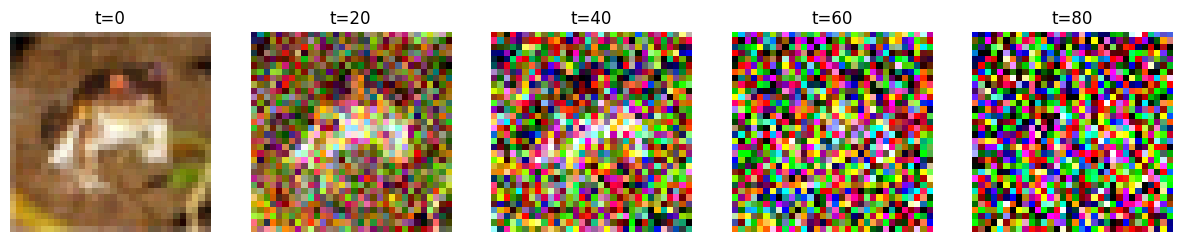

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
x_0, _ = dataset[0]  # Take the first image
x_0 = x_0.unsqueeze(0)  # Add batch dimension [1, C, H, W]

# Initialize noise scheduler
noise_scheduler = NoiseScheduler(num_timesteps=100, beta_start=0.0001, beta_end=0.02)

# Generate noisy images
x_T, noisy_images = add_noise(x_0, noise_scheduler, return_intermediate=True)

# Visualize intermediate steps
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(noisy_images[i * 20].squeeze().permute(1, 2, 0).cpu().numpy())  # Show every 20 steps
    ax.set_title(f"t={i*20}")
    ax.axis("off")
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def backward_process(model, noisy_image, noise_scheduler, device):
    """
    Perform the reverse diffusion process to generate an image from noise.
    
    Args:
        model: The trained U-Net model for predicting noise.
        noisy_image: The input noisy image (starting from pure noise at timestep T).
        noise_scheduler: The noise scheduler instance.
        device: Device (CPU/GPU) to run the computation on.

    Returns:
        The denoised image (approximation of original image).
    """
    
    num_steps = noise_scheduler.num_timesteps
    x_t = noisy_image.to(device)
    
    for t in reversed(range(num_steps)):
        t_tensor = torch.tensor([t], device=device, dtype=torch.long)
        predicted_noise = model(x_t, t_tensor)  # Predict noise
        
        alpha_cumprod_t = noise_scheduler.alphas_cumprod[t].to(device)
        sqrt_recip_alpha = torch.sqrt(1.0 / alpha_cumprod_t)
        sqrt_recipm1_alpha = torch.sqrt(1.0 / alpha_cumprod_t - 1)
        
        # Compute mean of the posterior distribution
        mean = sqrt_recip_alpha * (x_t - noise_scheduler.betas[t] * predicted_noise / sqrt_recipm1_alpha)
        
        if t > 0:
            noise = torch.randn_like(x_t)  # Sample noise for stochasticity
            x_t = mean + torch.sqrt(noise_scheduler.betas[t]) * noise  # Apply noise
        else:
            x_t = mean  # Last step, no noise added
    
    return x_t

In [12]:
x_t = backward_process(model=UNet, x_T, "linear", "CPU")

SyntaxError: positional argument follows keyword argument (1482366406.py, line 1)

In [9]:
class UNet(nn.Module):
    """
    A simple U-Net model for denoising in the DDPM framework.
    """
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        
        # Encoding path
        for feature in features:
            self.encoder.append(nn.Sequential(
                nn.Conv2d(in_channels, feature, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(feature, feature, kernel_size=3, stride=1, padding=1),
                nn.ReLU()
            ))
            in_channels = feature
        
        # Decoding path
        for feature in reversed(features):
            self.decoder.append(nn.Sequential(
                nn.Conv2d(feature * 2, feature, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(feature, feature, kernel_size=3, stride=1, padding=1),
                nn.ReLU()
            ))
        
        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x, t):
        skips = []
        for enc in self.encoder:
            x = enc(x)
            skips.append(x)
            x = F.avg_pool2d(x, kernel_size=2)  # Downsample
        
        for dec in self.decoder:
            x = F.interpolate(x, scale_factor=2, mode='nearest')  # Upsample
            skip = skips.pop()
            x = torch.cat((x, skip), dim=1)
            x = dec(x)
        
        return self.final_layer(x)